### Dataset info
Each chosen model went through a human assessment performed with the following methodology. Each of the assessors was given several tasks, which consisted of two parts:

1. Select one of four categories-characteristics of the provided set of tokens by answering the question ”Is it
possible to determine a common topic for the presented word set or at least for the most part of the set?”. They could answer one of the following: yes - if they agree with the statement and words have a strong connection between them, rather yes - if some words are too common or out of topic, rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics, no - when words seem to be unconnected.

2. In case of answering yes or rather yes on the first part of the task, assessors were asked to mark the words that they think are out of the topic. Also, they are asked to enter the topic’s name in free form (Name the common topic with one or few words).

In [117]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import dateutil
import numpy as np
from crowdkit.aggregation import MajorityVote, Wawa, DawidSkene
import re
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.join(sys.path[0], '../src'))

from data_preprocessing import TextPreprocessor

In [81]:
sns.set_style("whitegrid")

In [82]:
BASE_DIR = Path('EDA.ipynb').resolve().parent.parent
DATA_DIR = BASE_DIR.joinpath('data/TOLOKA_Markup')

FILE_NAME_1 = "assignments_from_pool_35355351__11-09-2022.tsv"
FILE_NAME_2 = "assignments_from_pool_35369313__12-09-2022.tsv"
FILE_NAME_3 = "assignments_from_pool_35432328__15-09-2022.tsv"
FILE_NAME_4 = "assignments_from_pool_35480971__19-09-2022.tsv"

FILE_1 = DATA_DIR.joinpath(FILE_NAME_1)
FILE_2 = DATA_DIR.joinpath(FILE_NAME_2)
FILE_3 = DATA_DIR.joinpath(FILE_NAME_3)
FILE_4 = DATA_DIR.joinpath(FILE_NAME_4)

In [83]:
df1 = pd.read_csv(FILE_1, sep="\t")
df2 = pd.read_csv(FILE_2, sep="\t")
df3 = pd.read_csv(FILE_3, sep="\t")
df4 = pd.read_csv(FILE_4, sep="\t")

data = pd.concat([df1, df2, df3, df4])

data.head(10)

,INPUT:exp_id,INPUT:wordset,INPUT:model_id,INPUT:topic_id,INPUT:dataset_name,INPUT:correct_bad_words,OUTPUT:quality,OUTPUT:bad_words,OUTPUT:topic_name,OUTPUT:golden_bad_words,...,ASSIGNMENT:task_suite_id,ASSIGNMENT:worker_id,ASSIGNMENT:status,ASSIGNMENT:started,ASSIGNMENT:submitted,ASSIGNMENT:accepted,ASSIGNMENT:rejected,ASSIGNMENT:skipped,ASSIGNMENT:expired,ASSIGNMENT:reward
0,28.0,driver sound running anybody memory wonder err...,631ba815291a690c5875365a,main24,20newsgroups,NaN,rather_bad,"{""driver"":false,""sound"":false,""running"":false,...",NaN,True,...,00021b7ad7--631df4b9a3d75c31d7b50ce1,35c9dec005edb17d8cc11946f9bc4b0f,APPROVED,2022-09-11T14:46:17.435,2022-09-11T14:48:35.368,2022-09-11T14:48:35.368,NaN,NaN,NaN,0.05
1,28.0,argument colorado conclusion music letter fall...,631bb8282d85fb2da960a6a5,main72,20newsgroups,NaN,bad,"{""argument"":false,""colorado"":false,""conclusion...",NaN,True,...,00021b7ad7--631df4b9a3d75c31d7b50ce1,35c9dec005edb17d8cc11946f9bc4b0f,APPROVED,2022-09-11T14:46:17.435,2022-09-11T14:48:35.368,2022-09-11T14:48:35.368,NaN,NaN,NaN,0.05
2,28.0,love uiuc cwru thought guess wrong sorry frank...,631b95224ac2fcd506e4781a,main4,20newsgroups,NaN,rather_bad,"{""love"":false,""uiuc"":false,""cwru"":false,""thoug...",NaN,True,...,00021b7ad7--631df4b9a3d75c31d7b50ce1,35c9dec005edb17d8cc11946f9bc4b0f,APPROVED,2022-09-11T14:46:17.435,2022-09-11T14:48:35.368,2022-09-11T14:48:35.368,NaN,NaN,NaN,0.05
3,28.0,engine modem rocket phone model yeast level fr...,631ba1dba6fa8975eb579abd,main13,20newsgroups,NaN,rather_bad,"{""engine"":false,""modem"":false,""rocket"":false,""...",NaN,True,...,00021b7ad7--631df4b9a3d75c31d7b50ce1,35c9dec005edb17d8cc11946f9bc4b0f,APPROVED,2022-09-11T14:46:17.435,2022-09-11T14:48:35.368,2022-09-11T14:48:35.368,NaN,NaN,NaN,0.05
4,28.0,turkish turkey turk armenia greek nazi azeri s...,631b96bea5a57837b841b5d1,main28,20newsgroups,NaN,rather_good,"{""turkish"":false,""turkey"":false,""turk"":false,""...",Race,True,...,00021b7ad7--631df4b9a3d75c31d7b50ce1,35c9dec005edb17d8cc11946f9bc4b0f,APPROVED,2022-09-11T14:46:17.435,2022-09-11T14:48:35.368,2022-09-11T14:48:35.368,NaN,NaN,NaN,0.05
5,28.0,country nazi germany german land europe money ...,631bb6faa5a57837b841d979,main3,20newsgroups,NaN,rather_good,"{""country"":false,""nazi"":false,""germany"":true,""...",Germany,True,...,00021b7ad7--631df4b9a3d75c31d7b50ce1,35c9dec005edb17d8cc11946f9bc4b0f,APPROVED,2022-09-11T14:46:17.435,2022-09-11T14:48:35.368,2022-09-11T14:48:35.368,NaN,NaN,NaN,0.05
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,28.0,attack lebanese muslim hernlem israeli left tr...,631b96bea5a57837b841b5d1,main1,20newsgroups,NaN,good,"{""attack"":false,""lebanese"":false,""muslim"":fals...",War,True,...,00021b7ad7--631df4c241d72e6d49540210,9c19d68db298943ca43bb07b3d320ac7,APPROVED,2022-09-11T14:46:26.065,2022-09-11T14:48:16.890,2022-09-11T14:48:16.890,NaN,NaN,NaN,0.05
8,28.0,curve drug create libertarian email hold graph...,631bb32427e1a64b30543798,main44,20newsgroups,NaN,bad,"{""curve"":false,""drug"":false,""create"":false,""li...",NaN,True,...,00021b7ad7--631df4c241d72e6d49540210,9c19d68db298943ca43bb07b3d320ac7,APPROVED,2022-09-11T14:46:26.065,2022-09-11T14:48:16.890,2022-09-11T14:48:16.890,NaN,NaN,NaN,0.05
9,28.0,nasa earth orbit mission launch satellite moon...,631b9549939bfaaca5600f20,main8,20newsgroups,NaN,good,"{""nasa"":false,""earth"":false,""orbit"":false,""mis...",Space exploration,True,...,00021b7ad7--631df4c241d72e6d49540210,9c19d68db298943ca43bb07b3d320ac7,APPROVED,2022-09-11T14:46:26.065,2022-09-11T14:48:16.890,2022-09-11T14:48:16.890,NaN,NaN,NaN,0.05


In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25922 entries, 0 to 9906
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   INPUT:exp_id                  22216 non-null  float64
 1   INPUT:wordset                 22216 non-null  object 
 2   INPUT:model_id                22216 non-null  object 
 3   INPUT:topic_id                22216 non-null  object 
 4   INPUT:dataset_name            22216 non-null  object 
 5   INPUT:correct_bad_words       0 non-null      float64
 6   OUTPUT:quality                20854 non-null  object 
 7   OUTPUT:bad_words              20854 non-null  object 
 8   OUTPUT:topic_name             9015 non-null   object 
 9   OUTPUT:golden_bad_words       20854 non-null  object 
 10  OUTPUT:golden_binary_quality  20854 non-null  object 
 11  GOLDEN:quality                0 non-null      float64
 12  GOLDEN:bad_words              0 non-null      float64
 13  GOLDEN:

There are columns and rows with all NaNs

In [85]:
# Remove rows with NaNs
data.dropna(axis=0, how='all', inplace=True)
# Remove columns with NaNs
data.dropna(axis=1, how='all', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22216 entries, 0 to 9905
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   INPUT:exp_id                  22216 non-null  float64
 1   INPUT:wordset                 22216 non-null  object 
 2   INPUT:model_id                22216 non-null  object 
 3   INPUT:topic_id                22216 non-null  object 
 4   INPUT:dataset_name            22216 non-null  object 
 5   OUTPUT:quality                20854 non-null  object 
 6   OUTPUT:bad_words              20854 non-null  object 
 7   OUTPUT:topic_name             9015 non-null   object 
 8   OUTPUT:golden_bad_words       20854 non-null  object 
 9   OUTPUT:golden_binary_quality  20854 non-null  object 
 10  GOLDEN:golden_binary_quality  3706 non-null   object 
 11  ASSIGNMENT:link               22216 non-null  object 
 12  ASSIGNMENT:task_id            22216 non-null  object 
 13  ASSIGNM

In [86]:
# Remove duplicates
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22216 entries, 0 to 9905
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   INPUT:exp_id                  22216 non-null  float64
 1   INPUT:wordset                 22216 non-null  object 
 2   INPUT:model_id                22216 non-null  object 
 3   INPUT:topic_id                22216 non-null  object 
 4   INPUT:dataset_name            22216 non-null  object 
 5   OUTPUT:quality                20854 non-null  object 
 6   OUTPUT:bad_words              20854 non-null  object 
 7   OUTPUT:topic_name             9015 non-null   object 
 8   OUTPUT:golden_bad_words       20854 non-null  object 
 9   OUTPUT:golden_binary_quality  20854 non-null  object 
 10  GOLDEN:golden_binary_quality  3706 non-null   object 
 11  ASSIGNMENT:link               22216 non-null  object 
 12  ASSIGNMENT:task_id            22216 non-null  object 
 13  ASSIGNM

As we can see from the information there are no duplicates 

In [87]:
# Analyze the INPUT data
data.iloc[0]["INPUT:wordset"]

'driver sound running anybody memory wonder error fine works appreciate check tape machine sorry utexas'

### Check skipped responses

In [88]:
print(f'The number of skipped responses: {len(data[data["ASSIGNMENT:skipped"].notnull()])}')
# Remove all skipped responses
data = data[data["ASSIGNMENT:skipped"].isna()]
# Remove skipped column
data.drop(labels=["ASSIGNMENT:skipped"], axis=1, inplace=True)
print(data.info())

The number of skipped responses: 36
<class 'pandas.core.frame.DataFrame'>
Index: 22180 entries, 0 to 9877
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   INPUT:exp_id                  22180 non-null  float64
 1   INPUT:wordset                 22180 non-null  object 
 2   INPUT:model_id                22180 non-null  object 
 3   INPUT:topic_id                22180 non-null  object 
 4   INPUT:dataset_name            22180 non-null  object 
 5   OUTPUT:quality                20854 non-null  object 
 6   OUTPUT:bad_words              20854 non-null  object 
 7   OUTPUT:topic_name             9015 non-null   object 
 8   OUTPUT:golden_bad_words       20854 non-null  object 
 9   OUTPUT:golden_binary_quality  20854 non-null  object 
 10  GOLDEN:golden_binary_quality  3700 non-null   object 
 11  ASSIGNMENT:link               22180 non-null  object 
 12  ASSIGNMENT:task_id            

### Check expared responses

In [89]:
print(f'The number of expared responses: {len(data[data["ASSIGNMENT:expired"].notnull()])}')
# Remove all expired responses
data = data[data["ASSIGNMENT:expired"].isna()]
# Remove expired column
data.drop(labels=["ASSIGNMENT:expired"], axis=1, inplace=True)
print(data.info())

The number of expared responses: 1326
<class 'pandas.core.frame.DataFrame'>
Index: 20854 entries, 0 to 9240
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   INPUT:exp_id                  20854 non-null  float64
 1   INPUT:wordset                 20854 non-null  object 
 2   INPUT:model_id                20854 non-null  object 
 3   INPUT:topic_id                20854 non-null  object 
 4   INPUT:dataset_name            20854 non-null  object 
 5   OUTPUT:quality                20854 non-null  object 
 6   OUTPUT:bad_words              20854 non-null  object 
 7   OUTPUT:topic_name             9015 non-null   object 
 8   OUTPUT:golden_bad_words       20854 non-null  object 
 9   OUTPUT:golden_binary_quality  20854 non-null  object 
 10  GOLDEN:golden_binary_quality  3479 non-null   object 
 11  ASSIGNMENT:link               20854 non-null  object 
 12  ASSIGNMENT:task_id          

### Calculate the duration of the response

In [90]:
# Convert from str to datetime
to_datetime = lambda x: dateutil.parser.parse(x)

data["ASSIGNMENT:submitted"] = [to_datetime(date) for date in data["ASSIGNMENT:submitted"].values]
data["ASSIGNMENT:started"] = [to_datetime(date) for date in data["ASSIGNMENT:started"].values]

data["ASSIGMNENT:time"] = data["ASSIGNMENT:submitted"] - data["ASSIGNMENT:started"]

to_seconds = lambda x: x.seconds 

data["ASSIGMNENT:time"] = [to_seconds(date) for date in data["ASSIGMNENT:time"]]
time_diff = data["ASSIGMNENT:time"].value_counts(ascending=True)

print(f"Minimum response time: {min(time_diff)} sec")
print(f"Maximum response time: {max(time_diff)} sec")

Minimum response time: 5 sec
Maximum response time: 168 sec


### Check experts

In [91]:
print(f'Experts: {set(data["INPUT:exp_id"])}')

Experts: {28.0}


                             INPUT:topic_id
INPUT:exp_id OUTPUT:quality                
28.0         bad                       7678
             good                      6921
             rather_bad                4161
             rather_good               2094


<AxesSubplot:xlabel='OUTPUT:quality', ylabel='count'>

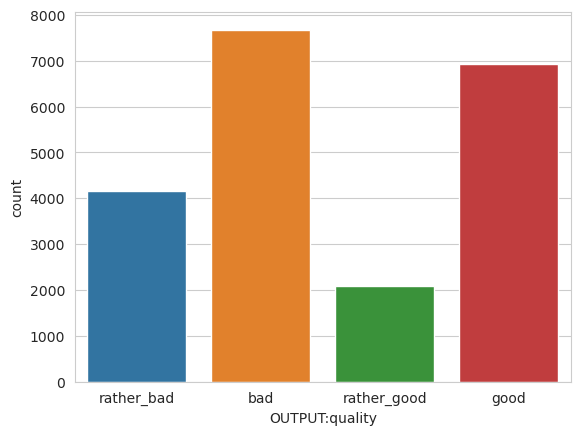

In [92]:
# Extract the distribution of responses
exp_ans_distrib = pd.DataFrame(data.groupby(["INPUT:exp_id", "OUTPUT:quality"])["INPUT:topic_id"].count())
print(exp_ans_distrib)
sns.countplot(data=data, x="OUTPUT:quality")

In [93]:
print(f"The number of unique input texts: {len(set(data['INPUT:wordset']))}")

The number of unique input texts: 3861


### Data preproccessing for topic_name

1) Lowercase

2) Remove punctuation 

3) Remove extra spaces

4) Tokenization 

5) Remove stop-words

6) Lemmatization (?)

In [94]:
data_preprocessor = TextPreprocessor(lang='eng')

In [95]:
example = 'Womans Thrashed in   a hotel room   !'
print(example)
example = data_preprocessor.lower_topic(example)
print(example)
example = data_preprocessor.remove_ext_spaces(example)
print(example)
example = data_preprocessor.remove_punct(example)
print(example)
example = data_preprocessor.tokenize(example)
print(example)
example = data_preprocessor.remove_stop_words(example)
print(example)
example = data_preprocessor.lemmatize(example)
print(example)

Womans Thrashed in   a hotel room   !
womans thrashed in   a hotel room   !
womans thrashed in a hotel room !
womans thrashed in a hotel room 
['womans', 'thrashed', 'in', 'a', 'hotel', 'room']
['womans', 'thrashed', 'hotel', 'room']
woman thrashed hotel room


In [96]:
data_preprocessor = TextPreprocessor(lang='eng')

data["OUTPUT:topic_name"] = [data_preprocessor.lower_topic(topic) for topic in data["OUTPUT:topic_name"]]
data["OUTPUT:topic_name"] = [data_preprocessor.remove_ext_spaces(topic) for topic in data["OUTPUT:topic_name"]]
data["OUTPUT:topic_name"] = [data_preprocessor.remove_punct(topic) for topic in data["OUTPUT:topic_name"]]
data["OUTPUT:topic_name"] = [data_preprocessor.tokenize(topic) for topic in data["OUTPUT:topic_name"]]
data["OUTPUT:topic_name"] = [data_preprocessor.remove_stop_words(topic) for topic in data["OUTPUT:topic_name"]]
data["OUTPUT:topic_name"] = [data_preprocessor.lemmatize(topic) for topic in data["OUTPUT:topic_name"]]

### Extract main inforamation

In [97]:
print("OUTPUT:golden_bad_words", set(data["OUTPUT:golden_bad_words"]))
print("OUTPUT:golden_binary_quality", set(data["OUTPUT:golden_binary_quality"]))
print("GOLDEN:golden_binary_quality", set(data["GOLDEN:golden_binary_quality"]))

OUTPUT:golden_bad_words {True}
OUTPUT:golden_binary_quality {False, True}
GOLDEN:golden_binary_quality {nan, True, False}


In [99]:
data = data[["INPUT:exp_id", "INPUT:wordset", "OUTPUT:quality", "OUTPUT:bad_words", "OUTPUT:topic_name"]]
data

,INPUT:exp_id,INPUT:wordset,OUTPUT:quality,OUTPUT:bad_words,OUTPUT:topic_name
0,28.0,driver sound running anybody memory wonder err...,rather_bad,"{""driver"":false,""sound"":false,""running"":false,...",NaN
1,28.0,argument colorado conclusion music letter fall...,bad,"{""argument"":false,""colorado"":false,""conclusion...",NaN
2,28.0,love uiuc cwru thought guess wrong sorry frank...,rather_bad,"{""love"":false,""uiuc"":false,""cwru"":false,""thoug...",NaN
3,28.0,engine modem rocket phone model yeast level fr...,rather_bad,"{""engine"":false,""modem"":false,""rocket"":false,""...",NaN
4,28.0,turkish turkey turk armenia greek nazi azeri s...,rather_good,"{""turkish"":false,""turkey"":false,""turk"":false,""...",race
...,...,...,...,...,...
9236,28.0,favorite enough blend black fuel fruity jet ro...,rather_bad,"{""favorite"":false,""enough"":false,""blend"":false...",NaN
9237,28.0,israel pres israeli encryption security arab c...,bad,"{""israel"":false,""pres"":false,""israeli"":false,""...",NaN
9238,28.0,ingredient natural corn free gluten chicken sy...,good,"{""ingredient"":false,""natural"":false,""corn"":fal...",pet diet
9239,28.0,anything juice wrong guess throw immediately t...,bad,"{""anything"":false,""juice"":false,""wrong"":false,...",NaN


In [100]:
data.loc[9240]["INPUT:wordset"]

'espresso cappuccino illy drink mate capsule http href com www issimo caffe roast dark cold'

In [101]:
data.loc[9240]["OUTPUT:bad_words"]

'{"espresso":false,"cappuccino":false,"illy":true,"drink":false,"mate":false,"capsule":false,"http":true,"href":true,"com":true,"www":true,"issimo":true,"caffe":false,"roast":false,"dark":false,"cold":false}'

### Aggregations
let's check how the answers ("OUTPUT:quality") are distributed within the same wordset

                INPUT:wordset
OUTPUT:quality               
bad                      7678
good                     6921
rather_bad               4161
rather_good              2094


<AxesSubplot:xlabel='OUTPUT:quality', ylabel='count'>

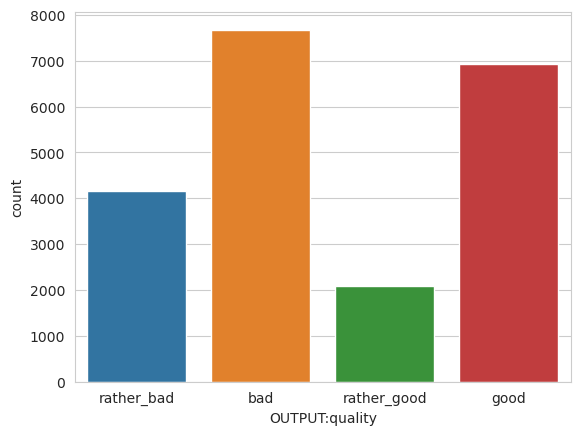

In [102]:
# Extract the distribution of responses (in entire dataset)
quality_distrib = pd.DataFrame(data.groupby(["OUTPUT:quality"])["INPUT:wordset"].count())
print(quality_distrib)
sns.countplot(data=data, x="OUTPUT:quality")

As we can see the data is poorly balanced. Let's combine good/rather_good and bad/raher_bad

                INPUT:wordset
OUTPUT:quality               
bad                     11839
good                     9015


<AxesSubplot:xlabel='OUTPUT:quality', ylabel='count'>

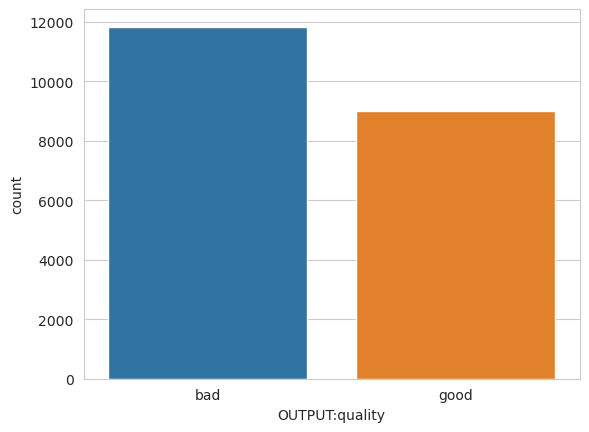

In [103]:
data_tmp = data.copy()
data_tmp["OUTPUT:quality"] = ["good" if answ in ["good", "rather_good"] else "bad" for answ in data["OUTPUT:quality"]]
# Extract the distribution of responses (in entire dataset)
quality_distrib_2 = pd.DataFrame(data_tmp.groupby(["OUTPUT:quality"])["INPUT:wordset"].count())
print(quality_distrib_2)
sns.countplot(data=data_tmp, x="OUTPUT:quality")

In this case we obtain more balanced classes.

**Task:** binary classification (traditional approaches->Catboost, LLM)

Let's check how quality is distributed within one wordset

In [104]:
wordset_quality_distrib = pd.DataFrame(data.groupby(["INPUT:wordset","OUTPUT:quality"])["OUTPUT:bad_words"].count())
wordset_quality_distrib

OUTPUT:bad_words
INPUT:wordset                                      OUTPUT:quality                  
able amaze fill glad stop daily fantastic move ... bad                            1
                                                   rather_bad                     2
able amaze fill stop glad daily fantastic move ... bad                            4
                                                   good                           1
                                                   rather_bad                     6
...                                                                             ...
year two size old last month every start week s... good                           1
                                                   rather_bad                     1
year work two every size old last month start l... bad                            2
                                                   rather_bad                     1
year work two size old last month start long we... bad                            3

[8786 rows x 1 columns]

The number of unique wordest: 8786

### Crowd-Kit aggregations

Read the annotations into Pandas Data Frame with columns task, worker, label.

Wawa: It calculates the majority opinion, and then re-weighs the performers' votes using the proportion of responses that coincided with the majority opinion.

In [136]:
def crowd_kit_agg(df):
    tmp_df = df.copy()
    tmp_df = tmp_df.rename(columns={"INPUT:exp_id": "worker", "INPUT:wordset": "task", "OUTPUT:quality": "label"})

    # Majority Vote Aggregation
    agg_mv = MajorityVote().fit_predict(tmp_df)
    # Wawa 
    agg_wawa = Wawa().fit_predict(tmp_df)
    # Dawid Skene
    agg_ds = DawidSkene(n_iter=10).fit_predict(tmp_df)

    # Let's compare the results
    ids = agg_mv.index

    agg_wawa = agg_wawa[ids]
    agg_ds = agg_ds[ids]

    mv_wawa = agg_mv == agg_wawa
    mv_ds = agg_mv == agg_ds
    wawa_ds = agg_wawa == agg_ds

    print(f"Majority Vote vs Wawa: True - {sum(mv_wawa)} False - {len(mv_wawa)-sum(mv_wawa)}")
    print(f"Majority Vote vs Dawid Skene: True - {sum(mv_ds)} False - {len(mv_ds)-sum(mv_ds)}")
    print(f"Wawa vs Dawid Skene: True - {sum(wawa_ds)} False - {len(wawa_ds)-sum(wawa_ds)}")

    agg_mv2 = pd.DataFrame(agg_mv)
    agg_wawa2 = pd.DataFrame(agg_wawa)
    agg_ds2 = pd.DataFrame(agg_ds)
    
    # Determine number of classes
    classes_num = len(set(tmp_df["label"]))
    
    fig = plt.figure(figsize=(15,10))
    plt.suptitle(f"The number of classes: {classes_num}", fontsize = 18)

    plt.subplot(131)
    plt.title('Majority Vote')
    sns.countplot(data=agg_mv2, x='agg_label')

    plt.subplot(132)
    plt.title('Wawa')
    sns.countplot(data=agg_wawa2, x='agg_label')

    plt.subplot(133)
    plt.title('Dawid Skene')
    sns.countplot(data=agg_ds2, x='agg_label')

    plt.tight_layout()
    plt.show()

Majority Vote vs Wawa: True - 3861 False - 0
Majority Vote vs Dawid Skene: True - 3393 False - 468
Wawa vs Dawid Skene: True - 3393 False - 468


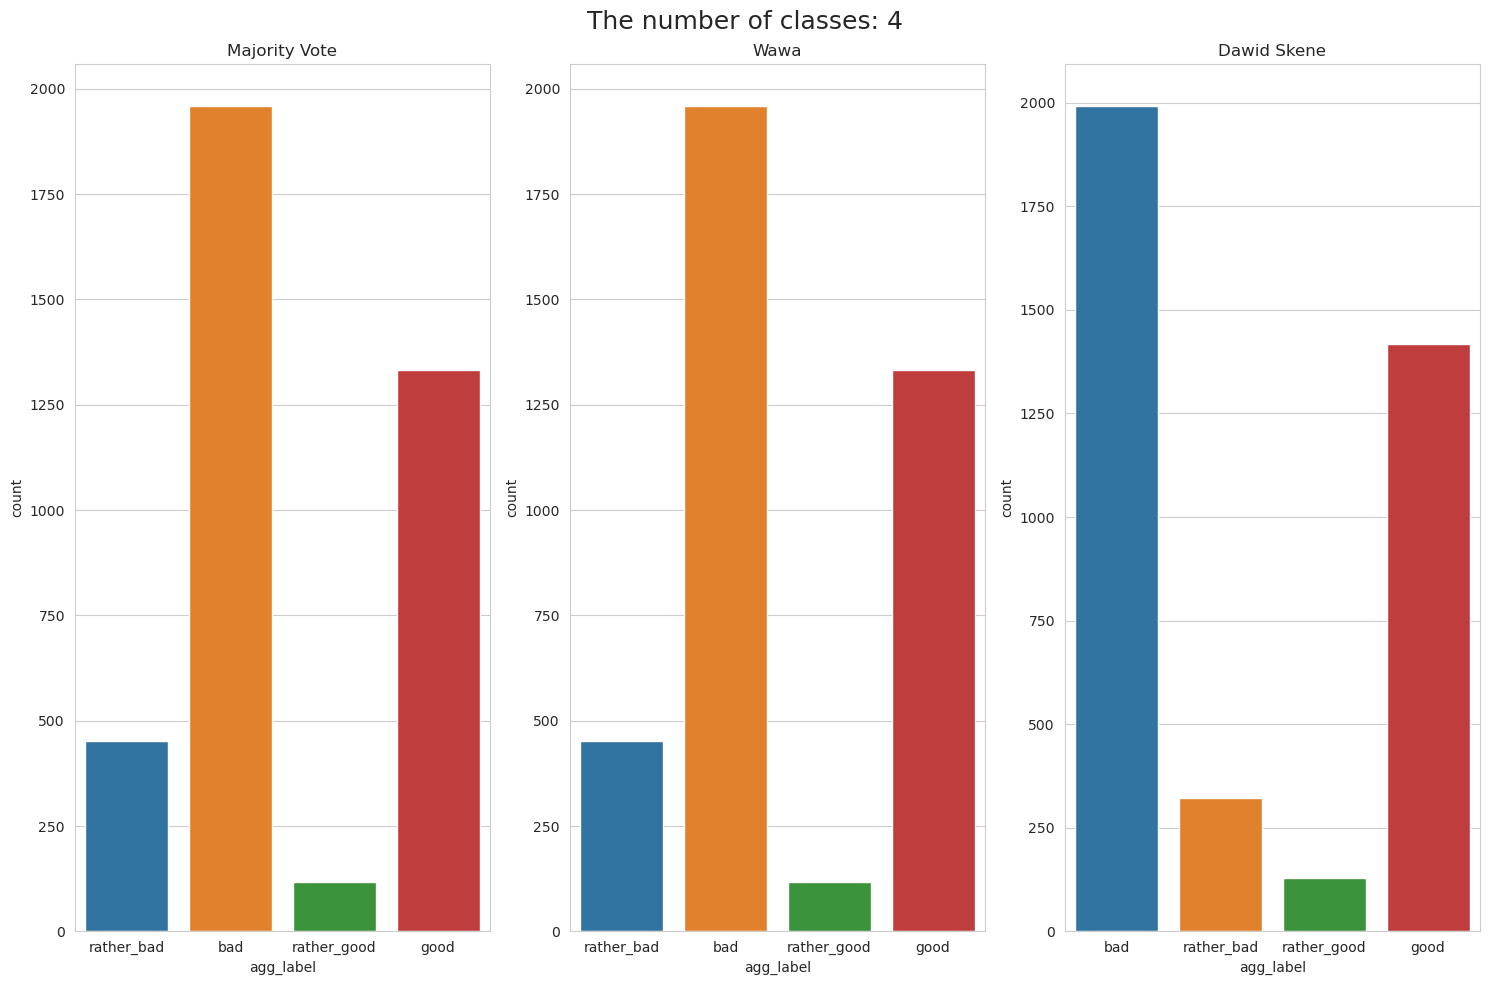

In [137]:
# For 4 classes
crowd_kit_agg(data)

Majority Vote vs Wawa: True - 3861 False - 0
Majority Vote vs Dawid Skene: True - 3828 False - 33
Wawa vs Dawid Skene: True - 3828 False - 33


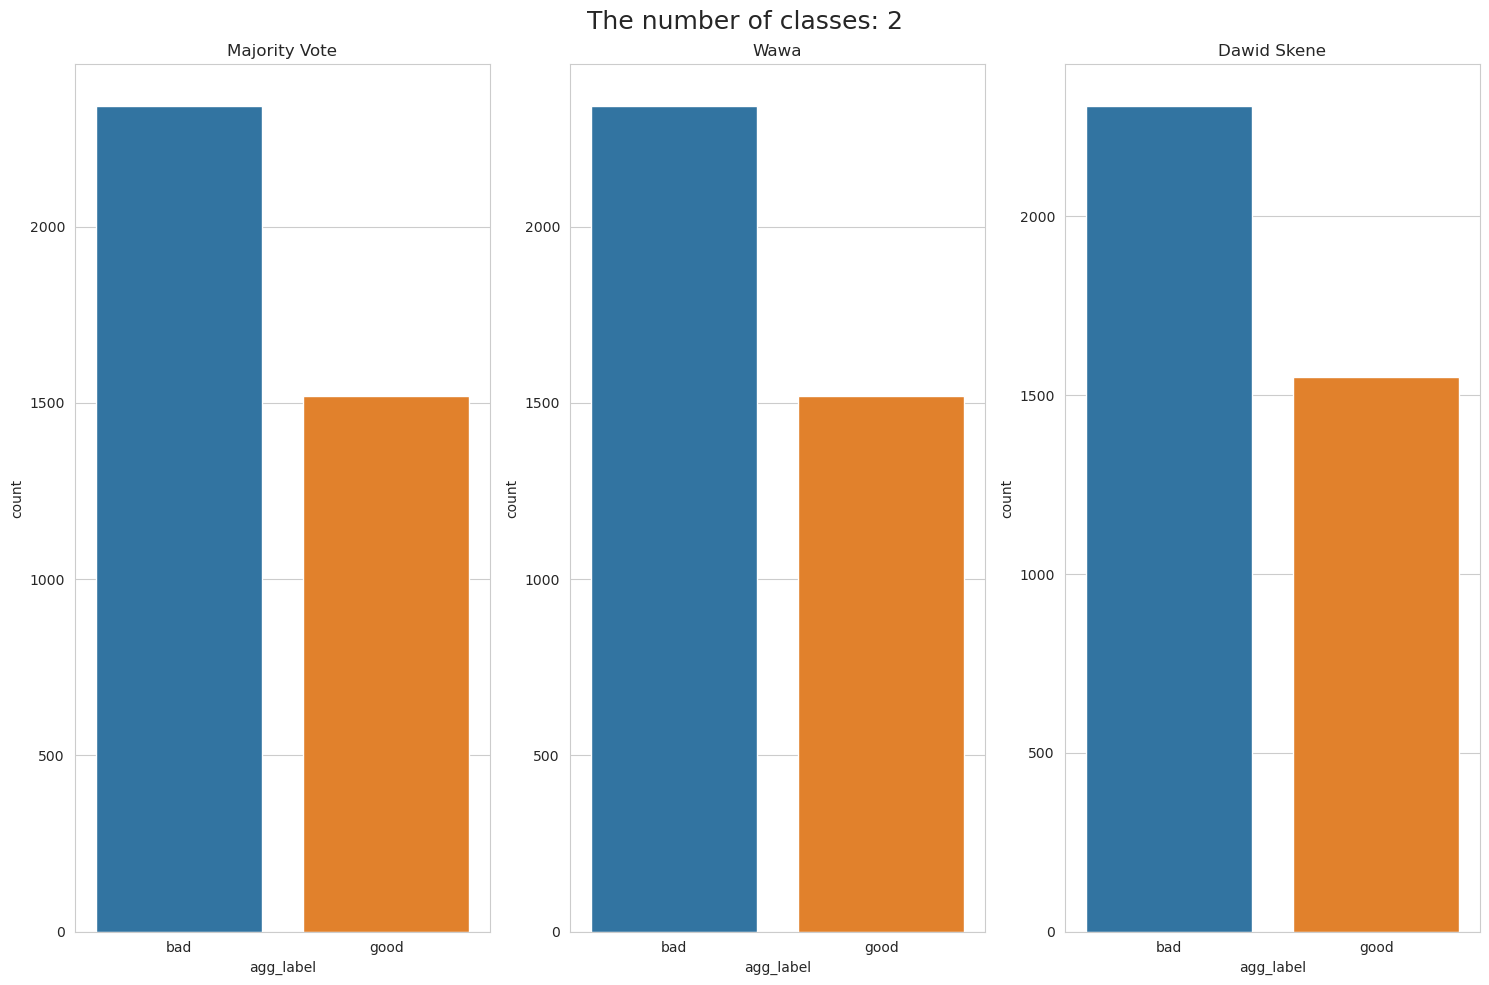

In [138]:
# For 2 classes
crowd_kit_agg(data_tmp)